O pacote yfinance utiliza uma API para acessar os dados do site Yahoo Finance. >Colocar a fonte<

In [1]:
import datetime
from datetime import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

import yfinance as yf

## A seguir as empresas do ramo de saúde listadas na B3

In [2]:
# Listando os ativos de saúde
nomes_dos_tickers = ["KRSA3.SA", "MATD3.SA", "ONCO3.SA", "RDOR3.SA", "HAPV3.SA", "ODPV3.SA", "QUAL3.SA", "DASA3.SA"]

# Criando DataFrames com os dados históricos para todos os ativos (doc:https://github.com/ranaroussi/yfinance/wiki/tickers#download)
ticks_df = yf.download(nomes_dos_tickers, period='max', rounding=True, auto_adjust=True)

# Verificando o DataFrame
ticks_df.tail(5)

[*********************100%%**********************]  8 of 8 completed


Close                                                        \
           DASA3.SA HAPV3.SA KRSA3.SA MATD3.SA ODPV3.SA ONCO3.SA QUAL3.SA   
Date                                                                        
2023-11-08    10.46     4.31     0.88     7.58    12.10    10.39     3.15   
2023-11-09    10.00     4.46     0.87     7.12    11.85    10.25     3.12   
2023-11-10    10.02     4.40     0.86     7.20    11.94    10.13     3.09   
2023-11-13    10.03     4.31     0.86     7.40    11.82    10.29     3.01   
2023-11-14    10.55     4.55     0.88     7.61    11.87    10.00     3.16   

                        High           ...     Open            Volume  \
           RDOR3.SA DASA3.SA HAPV3.SA  ... QUAL3.SA RDOR3.SA DASA3.SA   
Date                                   ...                              
2023-11-08    24.80    10.68     4.51  ...     2.92    24.20   325300   
2023-11-09    23.94    10.51     4.62  ...     3.15    25.02   504700   
2023-11-10    24.63    10.27     4.52  ...     3.11    24.06   614900   
2023-11-13    24.13    10.06     4.45  ...     3.09    24.66   488800   
2023-11-14    25.33    10.74     4.59  ...     3.04    24.30   680800   

                                                                    \
               HAPV3.SA   KRSA3.SA  MATD3.SA   ODPV3.SA   ONCO3.SA   
Date                                                                 
2023-11-08   87140500.0  1281400.0  309600.0  2783000.0  2491500.0   
2023-11-09  221385800.0   474300.0  210500.0  3434800.0  1767400.0   
2023-11-10   59942200.0   331400.0  359300.0  2385400.0  1408300.0   
2023-11-13   67402900.0   467700.0  344100.0  1019300.0  1754800.0   
2023-11-14  108160000.0  1577300.0  543100.0  2017000.0  7544600.0   

                                    
              QUAL3.SA    RDOR3.SA  
Date                                
2023-11-08  10401700.0  10835500.0  
2023-11-09   7141700.0   5130400.0  
2023-11-10   7713700.0   3861500.0  
2023-11-13   7221400.0   5932300.0  
2023-11-14  12949100.0   9003900.0  

[5 rows x 40 columns]

Limpeza

In [3]:
#Verificando se há dados nulos
ticks_df.isnull().sum()

Close   DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
High    DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
Low     DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
Open    DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
Volume  DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998


Descobrindo a data em que entraram na bolsa (IPO)

In [4]:
# Criando um DataFrame com a data da primeira operação registrada no objeto inicializado da API yFinance
data_inicial_df = pd.DataFrame({'Data_inicial': [yf.Ticker(t).history_metadata['firstTradeDate'] for t in nomes_dos_tickers]}, index=nomes_dos_tickers)

# Convertendo o formato de data
data_inicial_df['Data_inicial'] = (pd.to_datetime(data_inicial_df['Data_inicial'], unit='s').dt.date)

# Verificando
data_inicial_df.sort_values(by='Data_inicial')

,Data_inicial
DASA3.SA,2004-11-19
ODPV3.SA,2006-12-01
QUAL3.SA,2011-06-29
HAPV3.SA,2018-04-26
RDOR3.SA,2020-12-15
MATD3.SA,2021-05-13
KRSA3.SA,2021-08-16
ONCO3.SA,2021-09-21


In [5]:
# Verificando se há valores inválidos durante o período de registro de transações para cada ticker.
print('Valores nulos desde o início do registro:\n')

for ticker in data_inicial_df.index:
  # Atribuindo a data do ticker a uma variável.
  data_inicial = data_inicial_df.loc[ticker, 'Data_inicial']

  # Selecionando dentro do índice 'Close' as datas entre o período inicial e o último registro.
  periodo_selecionado = ticks_df['Close'][ticker].loc[data_inicial : ]

  # Imprimindo a soma de valores nulos dentro do período selecionado.
  print(f"Nome: {ticker} | data inicial: {data_inicial} | valores nulos: {periodo_selecionado.isnull().sum()}")

Valores nulos desde o início do registro:

Nome: KRSA3.SA | data inicial: 2021-08-16 | valores nulos: 0
Nome: MATD3.SA | data inicial: 2021-05-13 | valores nulos: 0
Nome: ONCO3.SA | data inicial: 2021-09-21 | valores nulos: 0
Nome: RDOR3.SA | data inicial: 2020-12-15 | valores nulos: 0
Nome: HAPV3.SA | data inicial: 2018-04-26 | valores nulos: 0
Nome: ODPV3.SA | data inicial: 2006-12-01 | valores nulos: 0
Nome: QUAL3.SA | data inicial: 2011-06-29 | valores nulos: 0
Nome: DASA3.SA | data inicial: 2004-11-19 | valores nulos: 0


Analisando os dados numéricos do DataFrame

In [6]:
# Como referencia usaremos sempre o índice 'Close'
ticks_df['Close'].describe()

,DASA3.SA,HAPV3.SA,KRSA3.SA,MATD3.SA,ODPV3.SA,ONCO3.SA,QUAL3.SA,RDOR3.SA
count,4723.000000,1378.000000,562.000000,627.000000,4204.000000,537.000000,3075.000000,725.000000
mean,20.222712,9.043254,2.777598,11.474960,8.070913,8.784879,15.614403,43.024386
std,20.850452,4.030342,1.987848,3.894327,3.903428,2.351033,7.291772,16.730539
min,4.660000,1.940000,0.740000,6.110000,1.080000,4.210000,2.800000,19.840000
25%,9.640000,5.446525,1.070000,8.325000,5.680000,6.780000,10.771600,29.050000
50%,12.880000,8.248450,2.570000,9.720000,7.970000,9.000000,13.763300,34.670000
75%,24.615000,12.411875,3.557500,15.240000,11.480000,10.630000,19.256000,62.350000
max,195.840000,18.151400,8.150000,21.220000,16.090000,15.410000,39.847300,73.300000


Verificamos que:


*   DASA3.SA - É a ação negociada a mais tempo com +4700 registros, confirmando os dados que temos sobre data inicial.
*   RDOR3.SA - Tem o maior valor médio, mais que o dobro da segunda ação com maior valor.
*   KRSA3.SA - Tem o menor média e desvio padrão em termos de valor financeiro, em contraste DASA3.SA tem a maior volatilidade com desvio padrão de ~R$20,00.
*   *Outliers* - A ação DASA3.SA tem uma diferença muito grande entre o terceiro quartil e o valor máximo, indicando possíveis '*outliers*'.




---



Visualização dos dados históricos dos ativos.

Vamos começar por plotar gráficos temporais

c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

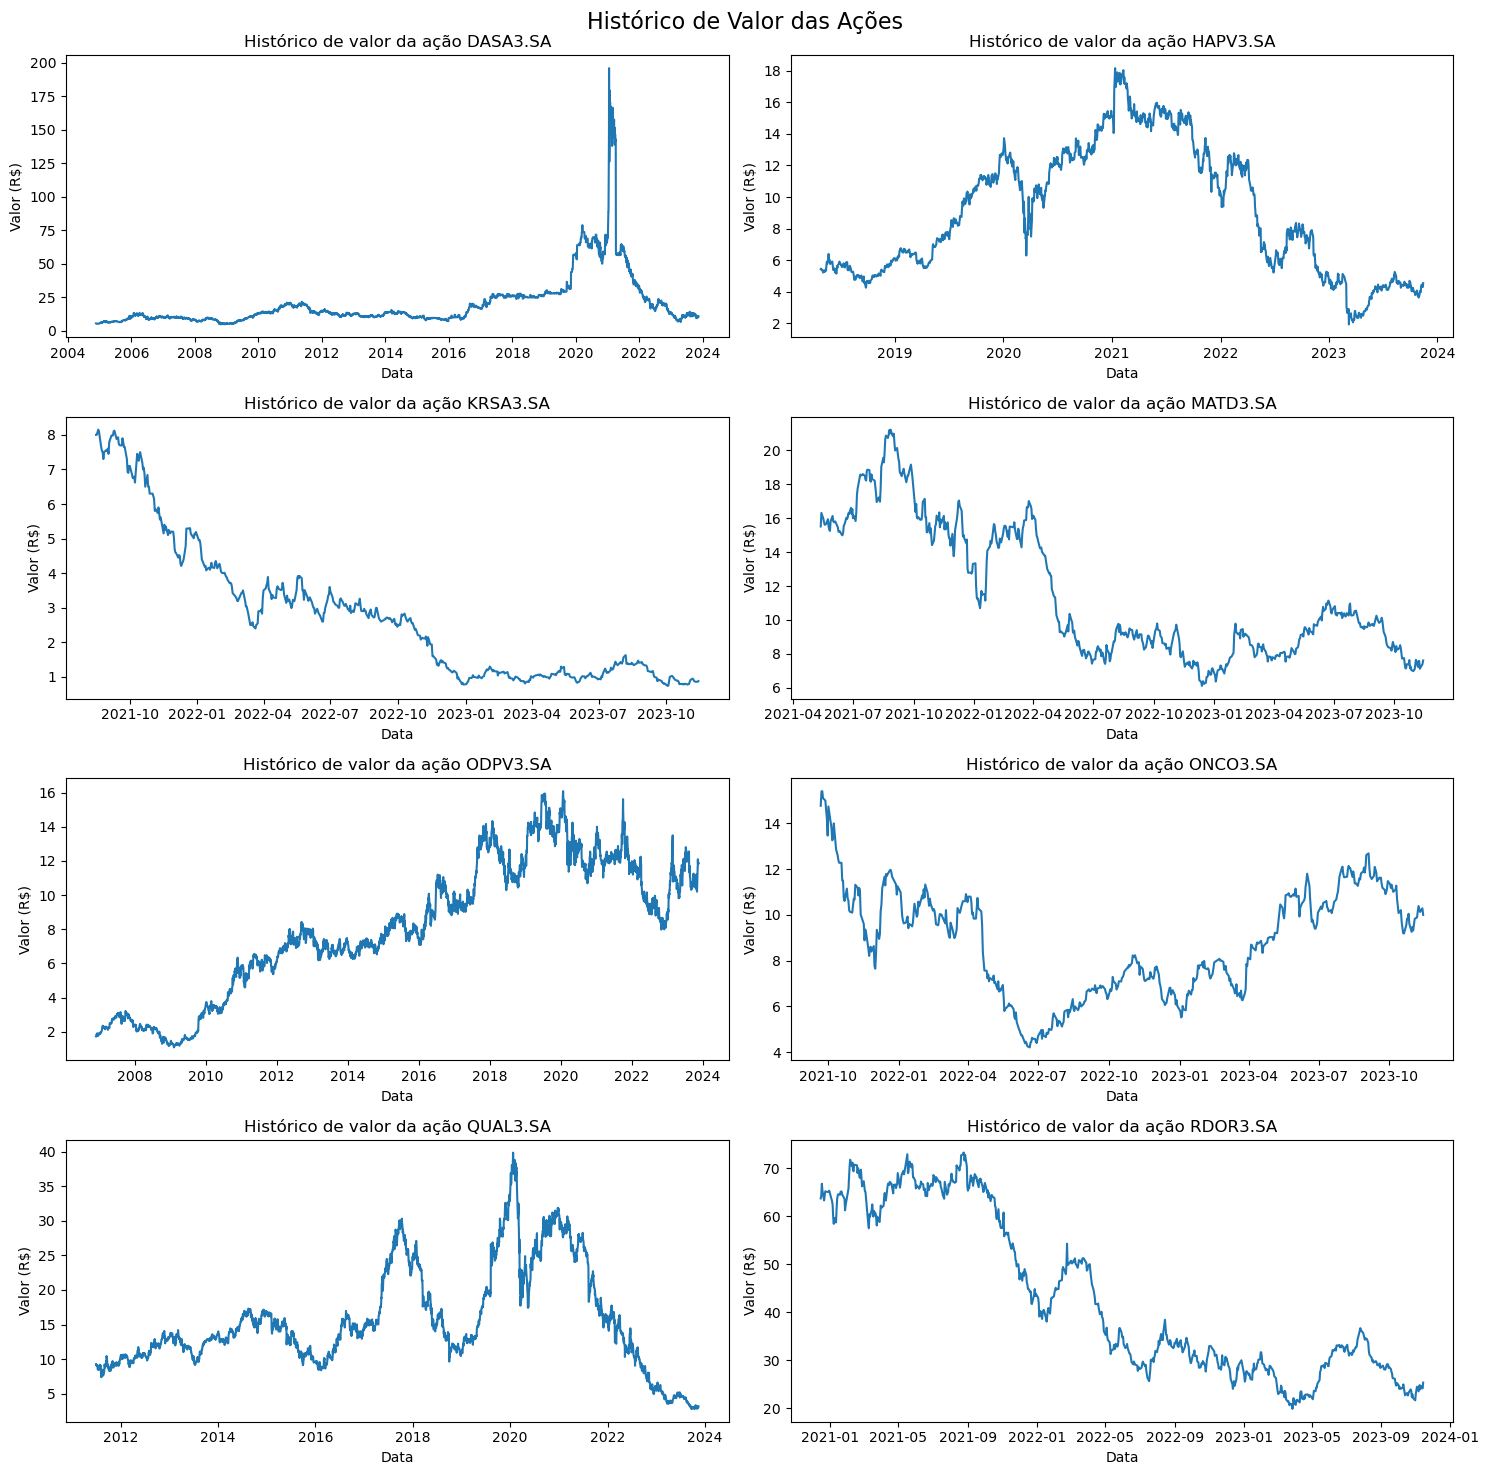

In [7]:
# Criando um grid de gráficos
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig.suptitle("Histórico de Valor das Ações", fontsize=16)

# Laço de repetição que cria os gráficos
for (nome, dados), ax in zip(ticks_df['Close'].items(), axes.ravel()):
    sns.lineplot(x=dados.index, y=dados.values, ax=ax)
    ax.set_title(f'Histórico de valor da ação {nome}')
    ax.set_ylabel('Valor (R$)')
    ax.set_xlabel('Data')

# Ajuste e visualização
plt.tight_layout()
plt.show()

A fim de compraração vamos pegar um período em que haja dados de todas as empresas

In [8]:
# Criando a variável que conterá a data mais recente
data_mais_recente = datetime.date

# Reduzindo a dimensão do DataFrame (transformando o índice de operação em coluna)
unstacked_ticks_df = ticks_df.stack(level=0).rename_axis(['Date', 'Operation'])

# Excluindo todas as linhas com dados não numéricos (NaN) nós chegamos à primeira data comum a todos os ativos
data_mais_recente = unstacked_ticks_df.dropna().index[0][0]

# Verificando
print(f"A data mais recente dentre o primeiro registro dos DataFrames é: {data_mais_recente.date()}")

A data mais recente dentre o primeiro registro dos DataFrames é: 2021-09-21


Vamos selecionar somente o período entre 21 de Setembro de 2021 e a data de registro mais recente:

In [9]:
# Selecionando o período encontrado previamente
ticks_2021_df = ticks_df.loc[data_mais_recente:]

# Conferindo se todos os DataFrames tem o mesmo número de linhas
print({key: df.shape[0] for key, df in ticks_2021_df['Close'].items()})

{'DASA3.SA': 537, 'HAPV3.SA': 537, 'KRSA3.SA': 537, 'MATD3.SA': 537, 'ODPV3.SA': 537, 'ONCO3.SA': 537, 'QUAL3.SA': 537, 'RDOR3.SA': 537}


Restringindo os dados a somente os registros de fechamento ('Close'), que iremos efetivamente usar.

In [10]:
close_2021_df = pd.DataFrame(ticks_2021_df['Close'], columns= ticks_2021_df['Close'].columns)
close_2021_df

,DASA3.SA,HAPV3.SA,KRSA3.SA,MATD3.SA,ODPV3.SA,ONCO3.SA,QUAL3.SA,RDOR3.SA
Date,,,,,,,,
2021-09-21,44.96,15.1600,7.90,18.32,13.00,14.77,20.7316,67.67
2021-09-22,45.15,14.5707,7.80,18.51,13.34,15.40,20.3943,67.20
2021-09-23,44.74,14.8703,7.65,18.52,13.33,15.41,20.4232,67.89
2021-09-24,45.61,14.7205,7.65,18.71,14.32,15.10,20.2401,67.40
2021-09-27,44.73,14.4509,7.30,19.16,14.44,15.00,20.1533,66.15
...,...,...,...,...,...,...,...,...
2023-11-08,10.46,4.3100,0.88,7.58,12.10,10.39,3.1500,24.80
2023-11-09,10.00,4.4600,0.87,7.12,11.85,10.25,3.1200,23.94
2023-11-10,10.02,4.4000,0.86,7.20,11.94,10.13,3.0900,24.63


Agora podemos fazer análises comparativas entre os ativos

c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

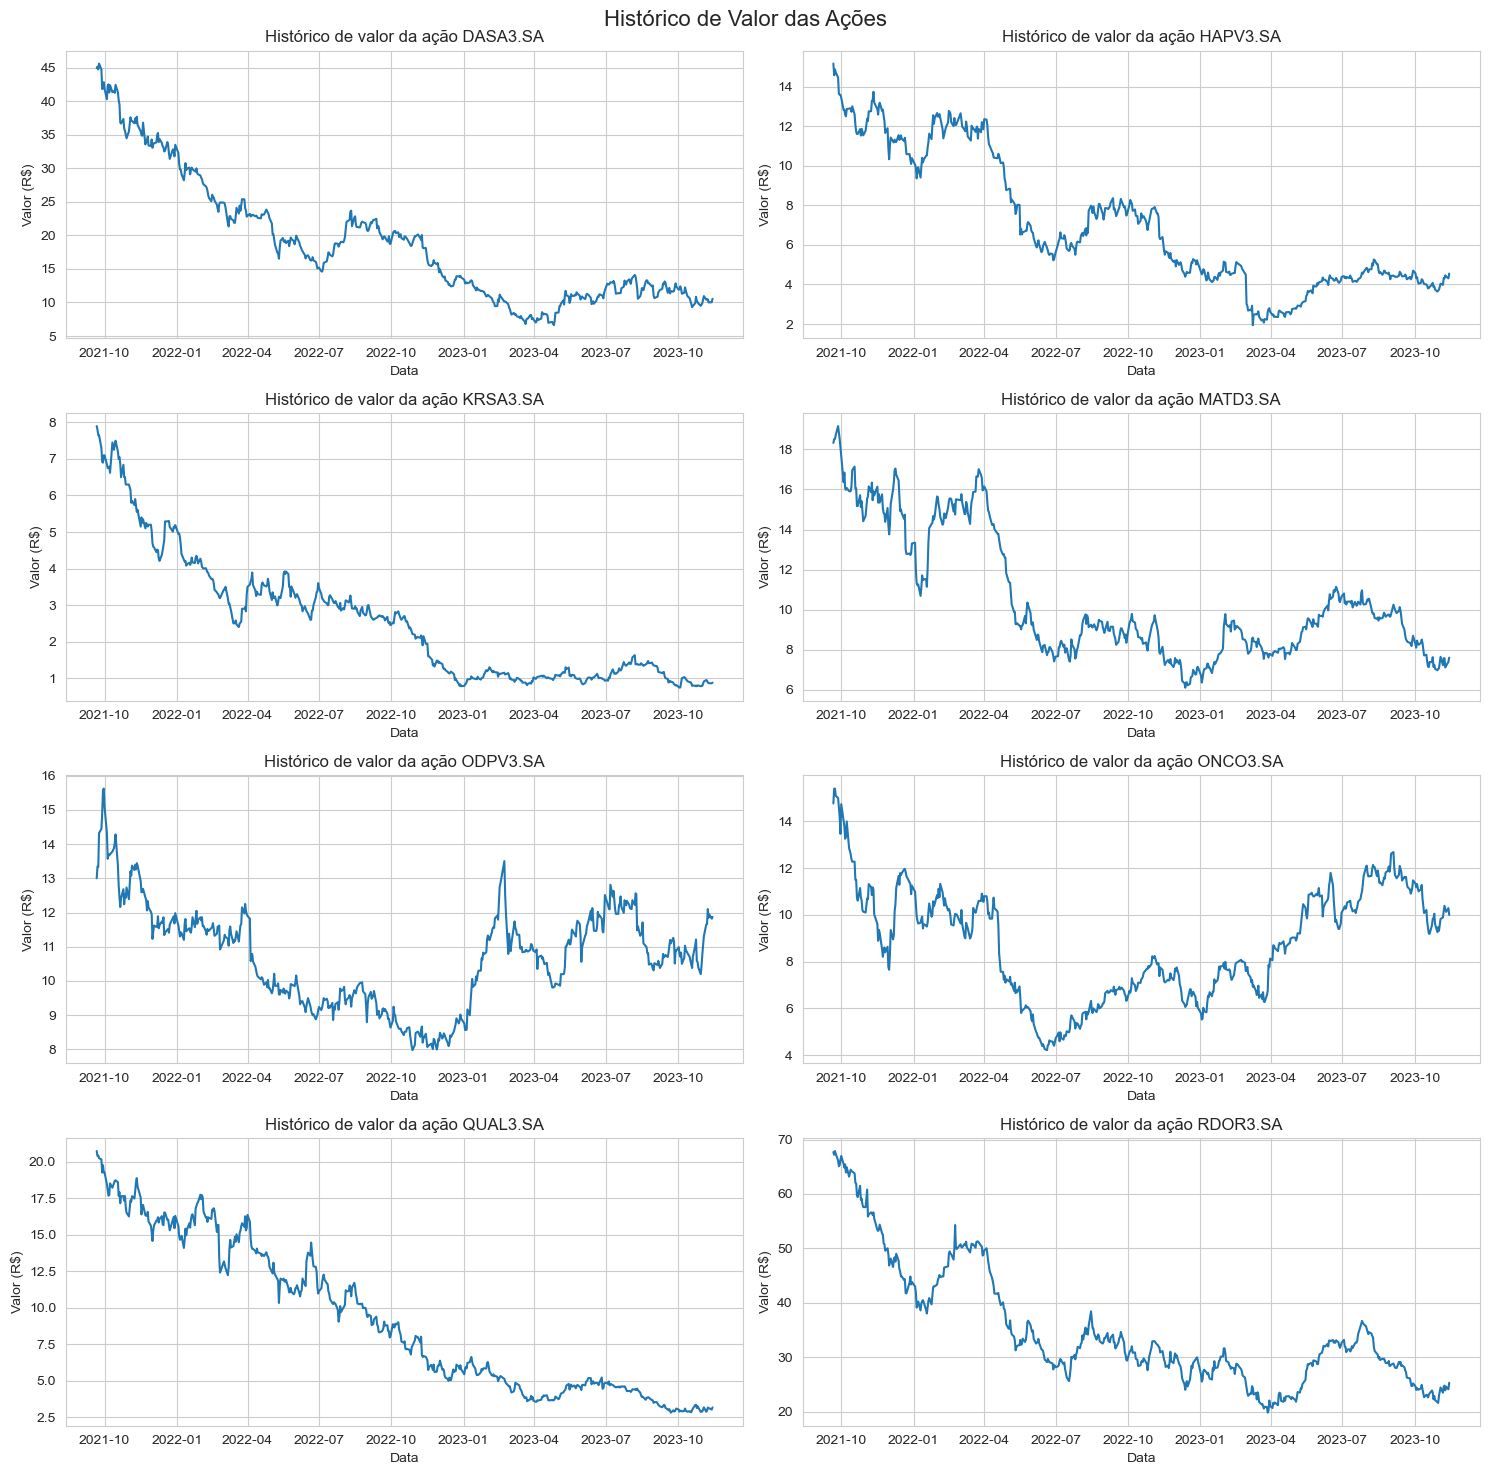

In [11]:
with sns.axes_style(style='whitegrid'):
  # Criando um grid de gráficos
  fig, axes = plt.subplots(4, 2, figsize=(15, 15))
  fig.suptitle("Histórico de Valor das Ações", fontsize=16)

  # Laço de repetição que cria os gráficos
  for (nome, dados), ax in zip(close_2021_df.items(), axes.ravel()):
      sns.lineplot(x=dados.index, y=dados.values, ax=ax)
      ax.set_title(f'Histórico de valor da ação {nome}')
      ax.set_ylabel('Valor (R$)')
      ax.set_xlabel('Data')

  # Ajuste e visualização
  plt.tight_layout()
  plt.show()

Vamos fazer uma correlação entre as ações e descobrir se há relação entre elas.

In [12]:
# Reset the index to have a clean DataFrame
close_2021_df = close_2021_df.reset_index()

In [13]:
# Usado o cmétodo .corr por se tratar de uma matriz
corr_df = close_2021_df.corr(method='pearson', numeric_only=True)
corr_df

,DASA3.SA,HAPV3.SA,KRSA3.SA,MATD3.SA,ODPV3.SA,ONCO3.SA,QUAL3.SA,RDOR3.SA
DASA3.SA,1.000000,0.933820,0.960930,0.820790,0.397832,0.307683,0.923468,0.912132
HAPV3.SA,0.933820,1.000000,0.880107,0.879837,0.366640,0.301448,0.937001,0.919047
KRSA3.SA,0.960930,0.880107,1.000000,0.770365,0.384044,0.229117,0.931113,0.872910
MATD3.SA,0.820790,0.879837,0.770365,1.000000,0.672711,0.588307,0.810573,0.935098
ODPV3.SA,0.397832,0.366640,0.384044,0.672711,1.000000,0.746024,0.320468,0.582578
ONCO3.SA,0.307683,0.301448,0.229117,0.588307,0.746024,1.000000,0.129820,0.469727
QUAL3.SA,0.923468,0.937001,0.931113,0.810573,0.320468,0.129820,1.000000,0.870624
RDOR3.SA,0.912132,0.919047,0.872910,0.935098,0.582578,0.469727,0.870624,1.000000


c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


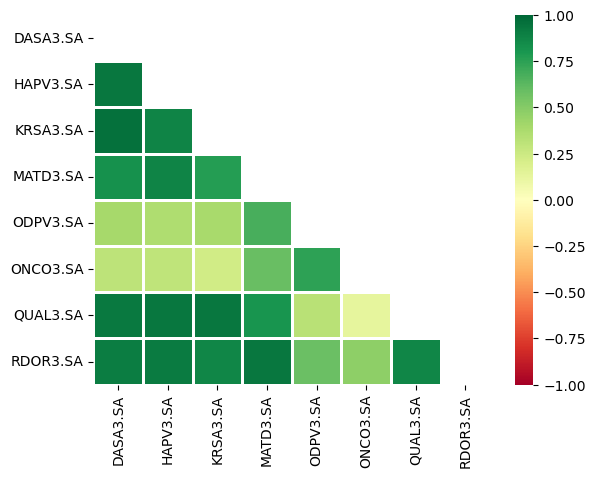

In [14]:
# Criando um numpy array identico (like) a corr_df e preenchido com zeros
mask = np.zeros_like(corr_df)

# Função do pacote NumPy que dado um array ou matriz (quadrada), seleciona a parte triângular superior.
mask[np.triu_indices_from(mask)] = True

# Gerando gráfico
sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2, annot=True, fmt=".2f")
plt.xticks(rotation=90)
plt.show()

Vamos separar os tickers que temos em dois setores: Planos de Saúde e Hospitais:

In [15]:
ticks_plano_saude_df = close_2021_df[['Date', 'HAPV3.SA', 'ODPV3.SA', 'QUAL3.SA', 'DASA3.SA']]
ticks_hospitais_df = close_2021_df[['Date', 'KRSA3.SA', 'MATD3.SA', 'ONCO3.SA', 'RDOR3.SA']]

In [16]:
ticks_plano_saude_df

,Date,HAPV3.SA,ODPV3.SA,QUAL3.SA,DASA3.SA
0,2021-09-21,15.1600,13.00,20.7316,44.96
1,2021-09-22,14.5707,13.34,20.3943,45.15
2,2021-09-23,14.8703,13.33,20.4232,44.74
3,2021-09-24,14.7205,14.32,20.2401,45.61
4,2021-09-27,14.4509,14.44,20.1533,44.73
...,...,...,...,...,...
532,2023-11-08,4.3100,12.10,3.1500,10.46
533,2023-11-09,4.4600,11.85,3.1200,10.00
534,2023-11-10,4.4000,11.94,3.0900,10.02
535,2023-11-13,4.3100,11.82,3.0100,10.03


In [17]:
ticks_plano_saude_df
ticks_hospitais_df

,Date,KRSA3.SA,MATD3.SA,ONCO3.SA,RDOR3.SA
0,2021-09-21,7.90,18.32,14.77,67.67
1,2021-09-22,7.80,18.51,15.40,67.20
2,2021-09-23,7.65,18.52,15.41,67.89
3,2021-09-24,7.65,18.71,15.10,67.40
4,2021-09-27,7.30,19.16,15.00,66.15
...,...,...,...,...,...
532,2023-11-08,0.88,7.58,10.39,24.80
533,2023-11-09,0.87,7.12,10.25,23.94
534,2023-11-10,0.86,7.20,10.13,24.63
535,2023-11-13,0.86,7.40,10.29,24.13


In [18]:
corr_planos_df = ticks_plano_saude_df.corr(method='pearson', numeric_only=True)
corr_hospitais_df = ticks_hospitais_df.corr(method='pearson', numeric_only=True)

#reset symbol as index (rather than 0-X)
corr_planos_df.head().reset_index().columns.name = None
corr_hospitais_df.head().reset_index().columns.name = None

In [19]:
# Criando um numpy array identico (like) a corr_df e preenchido com zeros
mask_segmentos = np.zeros_like(corr_planos_df)

# Função do pacote NumPy que dado um array ou matriz (quadrada), seleciona a parte triângular superior.
mask_segmentos[np.triu_indices_from(mask_segmentos)] = True

c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
c:\Users\ferna\anaconda3\envs\DataAnalysis\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


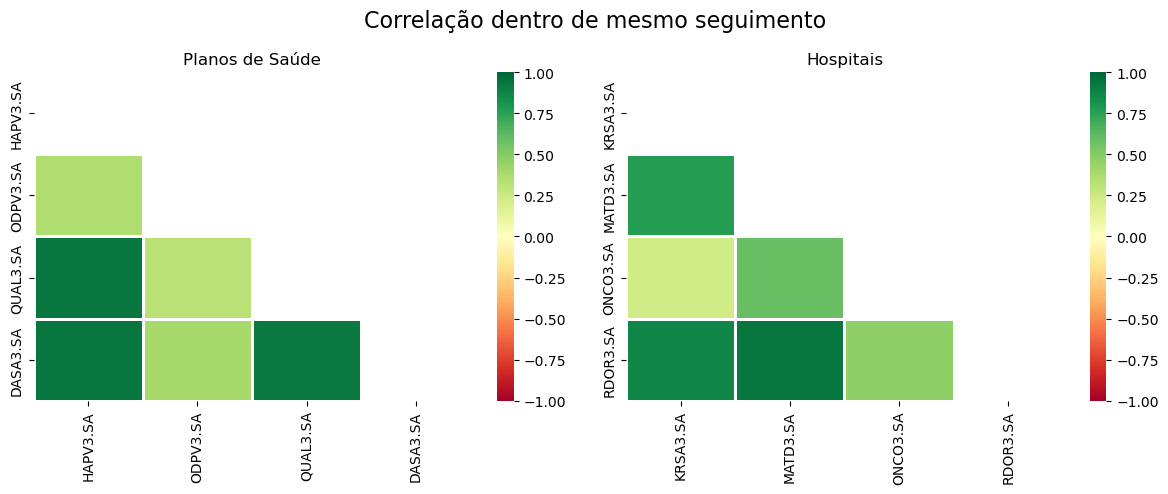

In [20]:
# Creating a grid of plots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Correlação dentro de mesmo seguimento", fontsize=16)

# Heatmap for corr_planos_df
sns.heatmap(corr_planos_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=mask_segmentos, linewidths=2, annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Planos de Saúde")

# Heatmap for corr_hospitais_df
sns.heatmap(corr_hospitais_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=mask_segmentos, linewidths=2, annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Hospitais")

#Rotacionando as etiquetas do eixo X para aprimorar clareza
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajuste e visualização
plt.tight_layout()
plt.show()


Vamos verificar a correlação com um benchmark da B3 chamado Ibovespa

In [21]:
# Inicializando o ticker ibovespa no pacote yFinance
ibovespa_ticker = yf.Ticker('^BVSP')

# Recebendo os dados começando pela data inicial em comum com todos os ativos
ibov_df = ibovespa_ticker.history(start=data_mais_recente)

In [22]:
# Mantendo somente a coluna de fechamento (close)
ibov_df = ibov_df[['Close']]

# Removendo a informação de hora do índice
ibov_df = ibov_df.set_index(pd.to_datetime(ibov_df.index.date)).rename(columns={'Close':'Valores'})

In [23]:
# Usado o método 'np.corrcoef' por se tratar de uma serie
ibov_corr = pd.DataFrame(columns=['Ticker', 'Correlacao'])

for t in close_2021_df.iloc[:,1:]:
  correlation = np.corrcoef(close_2021_df[t], ibov_df['Valores'])
  ibov_corr = pd.concat([ibov_corr, pd.DataFrame({'Ticker': [t], 'Correlacao': [np.round(correlation[0][1], 2)]})], ignore_index=True)


C:\Users\ferna\AppData\Local\Temp\ipykernel_804\3999216236.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ibov_corr = pd.concat([ibov_corr, pd.DataFrame({'Ticker': [t], 'Correlacao': [np.round(correlation[0][1], 2)]})], ignore_index=True)


In [24]:
ibov_corr

,Ticker,Correlacao
0,DASA3.SA,-0.10
1,HAPV3.SA,0.02
2,KRSA3.SA,-0.22
3,MATD3.SA,0.15
4,ODPV3.SA,0.21
5,ONCO3.SA,0.51
6,QUAL3.SA,-0.22
7,RDOR3.SA,0.09


## Machine Learning

In [25]:
# Função que cria a variável preditora 'x' e a variável alvo 'y'
def create_xy(df, ticker_list, begin_date, end_date, features, target, operation, days_before):
    # Transforma o DataFrame em um formato longo
    df = df.stack(level=0).rename_axis(['Date', 'Operation']).reset_index()
    
    # Se o parâmetro ticker_list for informado, seleciona as colunas desejadas e remove linhas com valores nulos
    if ticker_list:
        df = df.loc[:, ['Date', 'Operation', target] + ticker_list].dropna() # Seleciona as colunas desejadas e remove linhas com valores nulos
    else:
        df = df.dropna() # Seleciona as colunas desejadas e remove linhas com valores nulos
    
    # Transforma o DataFrame em um formato largo
    df = df.pivot(index='Date', columns='Operation').reset_index()
    # Renomeia as colunas
    df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in df.columns]
    
    
    # Seleciona as linhas com data maior ou igual a begin_date
    if begin_date:
        df = df[(df['Date'] >= str(begin_date))]
    # Seleciona as linhas com data menor ou igual a end_date
    if end_date:
        df = df[(df['Date']<= str(end_date))]
    
    # Adiciona uma coluna com o ano
    df['Year'] = df['Date'].dt.year
    # Adiciona uma coluna com o mês
    df['Month'] = df['Date'].dt.month
    # Adiciona uma coluna com o dia
    df['Day'] = df['Date'].dt.day
    # Adiciona uma coluna com o dia da semana
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    # Remove a coluna 'Date'
    df = df.drop(columns=['Date'])
    
    # Inicializa o objeto StandardScaler
    scaler = StandardScaler()
    # Normaliza os dados
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Seleciona a coluna alvo
    target_column = [col for col in df.columns if col.startswith(target) and col.endswith(operation)]

    # Cria a variável alvo 'y'e remove 'lag' dias
    y = df[target_column][:-days_before] if days_before != 0 else df[target_column]
    
    # Remove a coluna alvo e retorna n dias
    df = df.drop(columns=target_column)\
        .shift(days_before).dropna()
    
    # Seleciona as colunas de features
    if features:
        selected_columns = [col for col in df.columns if col.endswith(tuple(features))]
        df = df[['Year', 'Month', 'Day', 'DayOfWeek'] + selected_columns]

    # Cria a variável preditora 'x'
    x = df
    
    # Retorna as variáveis preditora e alvo
    return x, y

In [26]:
# Parametros
ticker_list = ['DASA3.SA', 'HAPV3.SA', 'QUAL3.SA',  'KRSA3.SA', 'MATD3.SA']
features_list = ['Open', 'Volume','Close']
begin_date = ''
end_date = ''
target = 'RDOR3.SA'
operation = 'Close'
days_before = 30

x, y = create_xy(ticks_df, ticker_list, begin_date, end_date, features_list, target, operation, days_before)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    x,  # The independent variable (predictor)
    y,  # The dependent variable (target)
    test_size=0.25,
    shuffle=False
)

In [28]:
#Fitting
model = LinearRegression()
model = model.fit(x_train, y_train)

In [29]:
predicted = model.predict(x_test)

In [30]:
compare_df = pd.DataFrame({'Actual_Price':y_test.values.ravel(), 'Predicted_Price':predicted.ravel()}, index=y_test.index)
compare_df

,Actual_Price,Predicted_Price
399,-1.197668,-1.141380
400,-1.236715,-1.210579
401,-1.210163,-1.205506
402,-1.216410,-1.170510
403,-1.295284,-1.295473
...,...,...
527,-0.803298,-0.733352
528,-0.864991,-0.780935
529,-0.914190,-0.803896
530,-0.912628,-0.834137


In [31]:
#Metricas
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predicted))
print('Mean Squared Error (MSE) :', metrics.mean_squared_error(y_test, predicted))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

# Acuracia
x_acc = compare_df.Actual_Price.mean()
y_acc = compare_df.Predicted_Price.mean()
Accuracy = x_acc/y_acc*100
print("The accuracy of the model is " , Accuracy)

# Cross Validation
cv_scores = cross_val_score(model, y_test, predicted, cv=5)
print(f"Cross-validation scores: {cv_scores}")

Mean Absolute Error (MAE): 0.04140978857404042
Mean Squared Error (MSE) : 0.002532077258871729
Root Mean Squared Error (RMSE): 0.050319750186897085
The accuracy of the model is  104.07965409495364
Cross-validation scores: [0.60522235 0.96632163 0.43531565 0.92651096 0.74835737]


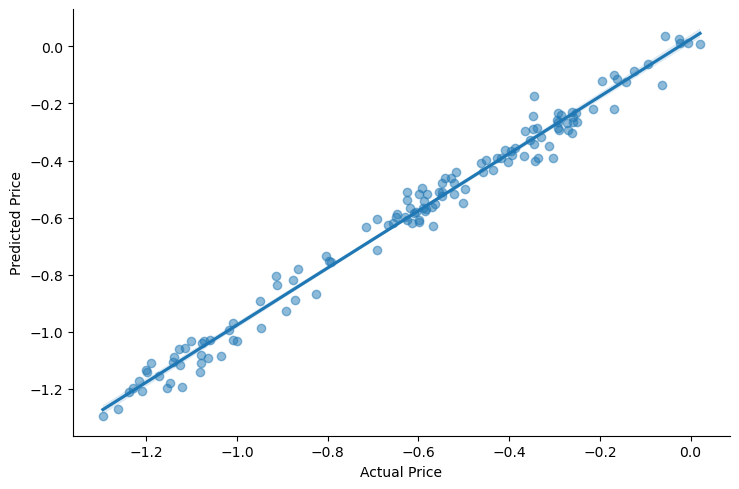

In [32]:
# Plot_scatter
sns.lmplot(x='Actual_Price', y='Predicted_Price', data=compare_df, height=5, aspect=1.5, fit_reg=True, scatter_kws={'alpha':0.5})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

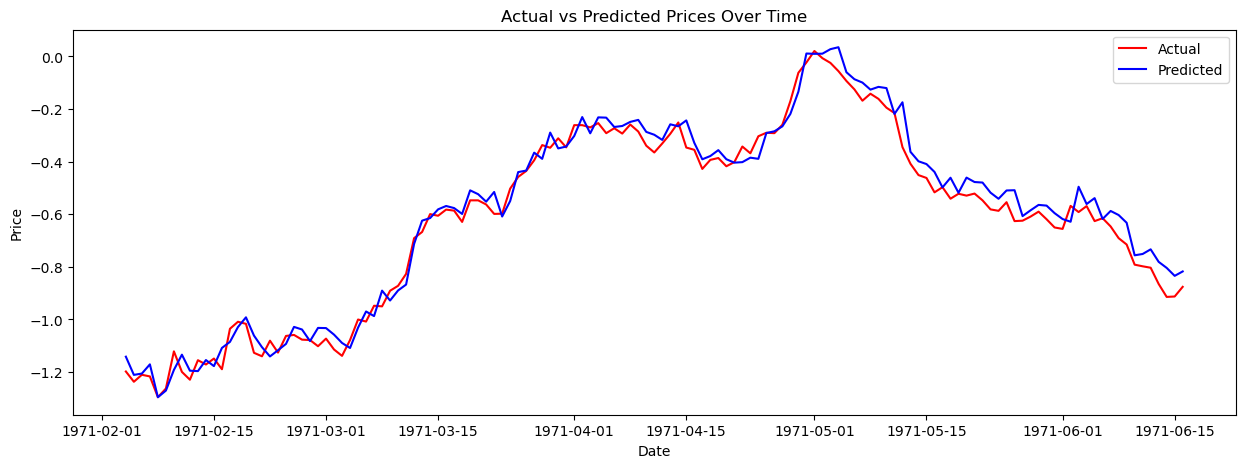

In [33]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(15,5))

# Plot the actual data
ax.plot_date(compare_df.index, compare_df.Actual_Price, 'r-', label='Actual')

# Plot the predicted data
ax.plot_date(compare_df.index, compare_df.Predicted_Price, 'b-', label='Predicted')

# Set the labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Actual vs Predicted Prices Over Time')

# Add a legend
ax.legend()

# Display the plot
plt.show()

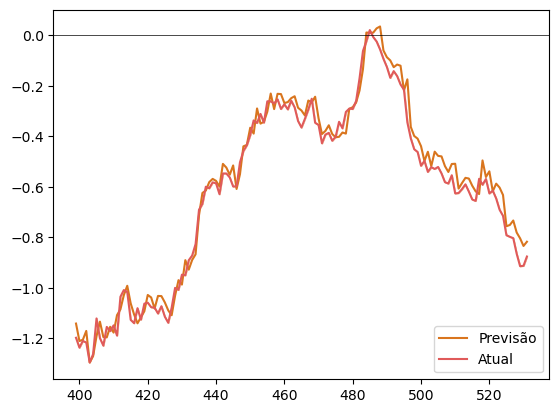

In [34]:
predicted_series = pd.Series(predicted.ravel(), index=y_test.index)
plt.plot(predicted_series.index, predicted_series, label=f'Previsão', color='#d9751e')
plt.plot(y_test.index, y_test, label='Atual', color='#e05a5a')
plt.fill_between(x=predicted_series.index, y1=y_test.values.ravel(), y2=y_test.values.ravel(), alpha=.3, color='#d9751e')
plt.axhline(y=0, color='black', linewidth=.5)
plt.legend()
plt.show()

In [35]:
class DataPreparation:
    def __init__(self, df, ticker_list, begin_date, end_date, features, target, operation, days_before):
        self.df = df.copy()  # Store a copy of the original DataFrame
        self.transformed_df = df  # This is the DataFrame you'll apply transformations to
        self.ticker_list = ticker_list
        self.begin_date = begin_date
        self.end_date = end_date
        self.features = features
        self.target = target
        self.operation = operation
        self.days_before = days_before

    def transform_to_long_format(self):
        self.transformed_df = self.transformed_df.stack(level=0).rename_axis(['Date', 'Operation']).reset_index()

    def select_columns_and_drop_na(self):
        if self.ticker_list:
            self.transformed_df = self.transformed_df.loc[:, ['Date', 'Operation', self.target] + self.ticker_list].dropna()
        else:
            self.transformed_df = self.transformed_df.dropna()

    def transform_to_wide_format(self):
        self.transformed_df = self.transformed_df.pivot(index='Date', columns='Operation').reset_index()
        self.transformed_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in self.transformed_df.columns]

    def filter_by_date(self):
        if self.begin_date:
            self.transformed_df = self.transformed_df[(self.transformed_df['Date'] >= str(self.begin_date))]
        if self.end_date:
            self.transformed_df = self.transformed_df[(self.transformed_df['Date']<= str(self.end_date))]

    def add_date_parts(self):
        self.transformed_df['Year'] = self.transformed_df['Date'].dt.year
        self.transformed_df['Month'] = self.transformed_df['Date'].dt.month
        self.transformed_df['Day'] = self.transformed_df['Date'].dt.day
        self.transformed_df['DayOfWeek'] = self.transformed_df['Date'].dt.dayofweek
        self.transformed_df = self.transformed_df.drop(columns=['Date'])

    def normalize_data(self):
        scaler = StandardScaler()
        self.transformed_df = pd.DataFrame(scaler.fit_transform(self.transformed_df), columns=self.transformed_df.columns)

    def create_target_variable(self):
        target_column = [col for col in self.transformed_df.columns if col.startswith(self.target) and col.endswith(self.operation)]
        self.y = self.transformed_df[target_column][:-self.days_before] if self.days_before != 0 else self.transformed_df[target_column]
        self.transformed_df = self.transformed_df.drop(columns=target_column).shift(self.days_before).dropna()

    def select_feature_columns(self):
        if self.features:
            selected_columns = [col for col in self.transformed_df.columns if col.endswith(tuple(self.features))]
            self.transformed_df = self.transformed_df[['Year', 'Month', 'Day', 'DayOfWeek'] + selected_columns]

    def create_predictor_variable(self):
        self.x = self.transformed_df

    def create_xy(self):
        self.transform_to_long_format()
        self.select_columns_and_drop_na()
        self.transform_to_wide_format()
        self.filter_by_date()
        self.add_date_parts()
        self.normalize_data()
        self.create_target_variable()
        self.select_feature_columns()
        self.create_predictor_variable()
        return self.x, self.y
    
from sklearn.model_selection import train_test_split

class ModelTraining:
    def __init__(self, model, x, y, test_size=0.2):
        self.model = model
        self.x = x
        self.y = y
        self.test_size = test_size

    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x, self.y, test_size=self.test_size, shuffle=False)

    def fit_model(self):
        self.model.fit(self.x_train, self.y_train)

    def predict(self):
        self.predicted = self.model.predict(self.x_test)

    def train_and_predict(self):
        self.split_data()
        self.fit_model()
        self.predict()
        return self.x_test, self.y_test, self.predicted

In [36]:
# Parametros
df = ticks_df
ticker_list = ['DASA3.SA', 'HAPV3.SA', 'QUAL3.SA',  'KRSA3.SA', 'MATD3.SA']
features = ['Open', 'Volume','Close']
begin_date = ''
end_date = ''
target = 'RDOR3.SA'
operation = 'Close'
days_before = 30

# Create an instance of the DataPreparation class
data_prep = DataPreparation(df, ticker_list, begin_date, end_date, features, target, operation, days_before)

# Use the create_xy method to prepare the data
x, y = data_prep.create_xy()

In [37]:
# Assume we have a model `model`
model = LinearRegression()

# Create an instance of the ModelTraining class
model_training = ModelTraining(model, x, y)

# Use the train_and_predict method to train the model and make predictions
x_test, y_test, predicted = model_training.train_and_predict()

In [38]:
compare_df = pd.DataFrame({'Actual_Price':y_test.values.ravel(), 'Predicted_Price':predicted.ravel()}, index=y_test.index)

In [39]:
#Metricas
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predicted))
print('Mean Squared Error (MSE) :', metrics.mean_squared_error(y_test, predicted))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

# Acuracia
x_acc = compare_df.Actual_Price.mean()
y_acc = compare_df.Predicted_Price.mean()
Accuracy = x_acc/y_acc*100
print("The accuracy of the model is " , Accuracy)

# Cross Validation
cv_scores = cross_val_score(model, y_test, predicted, cv=5)
print(f"Cross-validation scores: {cv_scores}")

Mean Absolute Error (MAE): 0.03915891357648829
Mean Squared Error (MSE) : 0.0023617806186100802
Root Mean Squared Error (RMSE): 0.04859815447740871
The accuracy of the model is  103.9498804476897
Cross-validation scores: [0.91805348 0.76606774 0.900359   0.88923001 0.73689775]


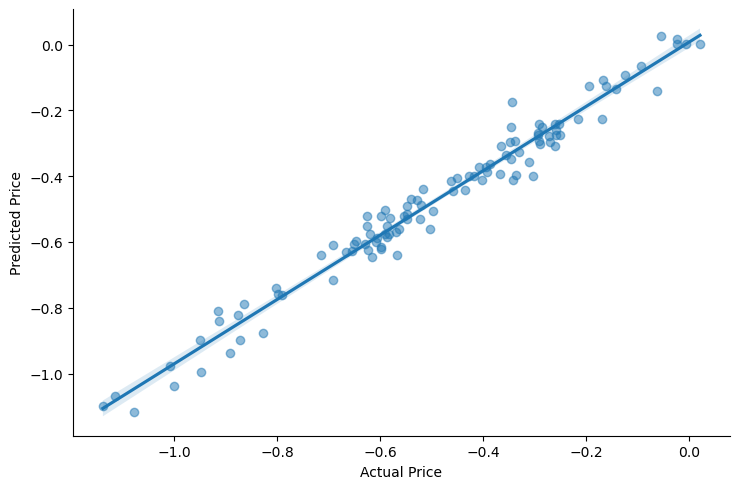

In [40]:
# Plot_scatter
sns.lmplot(x='Actual_Price', y='Predicted_Price', data=compare_df, height=5, aspect=1.5, fit_reg=True, scatter_kws={'alpha':0.5})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

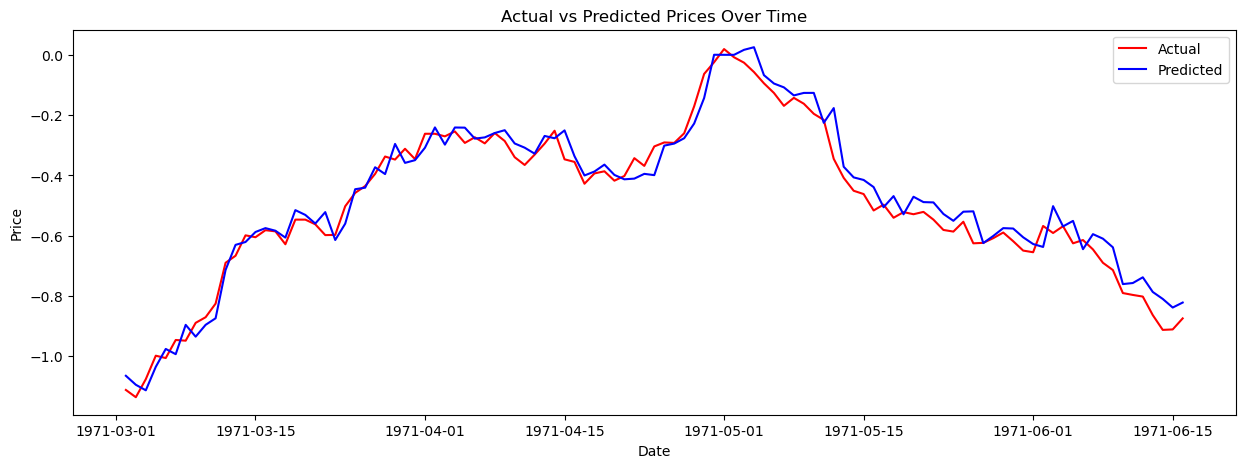

In [41]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(15,5))

# Plot the actual data
ax.plot_date(compare_df.index, compare_df.Actual_Price, 'r-', label='Actual')

# Plot the predicted data
ax.plot_date(compare_df.index, compare_df.Predicted_Price, 'b-', label='Predicted')

# Set the labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Actual vs Predicted Prices Over Time')

# Add a legend
ax.legend()

# Display the plot
plt.show()